In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import pickle
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, classification_report
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error
from sklearn.metrics import ConfusionMatrixDisplay

In [3]:
df = pd.read_csv('../data/weblogs1.csv')

df = df.drop(['ID', 'STANDARD_DEVIATION', 'SF_REFERRER', 'SF_FILETYPE', 'OTHER_METHOD', 'POST_METHOD', 'HEAD_METHOD', 'HTTP_RESPONSE_3XX',  'HTTP_RESPONSE_4XX', 'HTTP_RESPONSE_5XX','REPEATED_REQUESTS'], axis=1)
X = df.drop(['ROBOT'], axis=1)
y = df['ROBOT']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(51187, 20) (12797, 20) (51187,) (12797,)


## DecisionTreeClassifier resultaten vergelijken met BaggingClassifier (Met en zonder OOB), met AdaBoostClassifier, GradientBoostClassifier en RandomForestClassifier

### Alle models trainen met en zonder scaling en resultaten vergelijken

De ranges van de waarden bij de features verschillen soms erg veel (De number of request bvb kan oplopen tot een nummer groter dan 9000 terwijl er bij de HTTP_REQUEST soms getallen van 0.3 zijn) --> testen of de models betere resultaten geven wanneer features gescaled zijn

### Zonder scaling

##### DecisionTreeClassifier

{'max_depth': 29, 'min_samples_leaf': 3, 'min_samples_split': 12}


0.9766351488630147


              precision    recall  f1-score   support

           0       0.98      0.99      0.99     10337
           1       0.95      0.93      0.94      2460

    accuracy                           0.98     12797
   macro avg       0.97      0.96      0.96     12797
weighted avg       0.98      0.98      0.98     12797



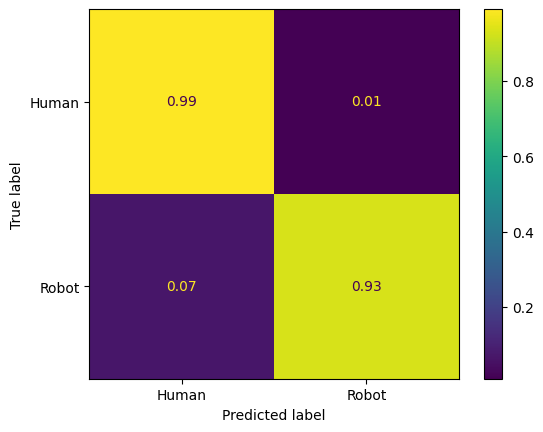

In [4]:
param_grid_dtc = {'max_depth': np.arange(2, 40), 'min_samples_split': np.arange(2, 20, 2), 'min_samples_leaf': np.arange(1, 10)}

grid_search_dtc = GridSearchCV(DecisionTreeClassifier(random_state=42), param_grid=param_grid_dtc, cv=5, scoring='precision', return_train_score=True, n_jobs=-1)

grid_search_dtc.fit(X_train, y_train)

print(grid_search_dtc.best_params_)
print("\n")

dt_clf = grid_search_dtc.best_estimator_

dt_clf.fit(X_train, y_train)

y_pred_dtc = dt_clf.predict(X_test)

print(accuracy_score(y_test, y_pred_dtc))
print("\n")
print(classification_report(y_test, y_pred_dtc))

cm = np.round(confusion_matrix(y_test, y_pred_dtc, normalize='true'), 2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Robot'])
disp.plot()

In [9]:
filename = '../main_models/decision_tree_classifier_drop2.sav'
pickle.dump(dt_clf, open(filename, 'wb'))

##### BaggingClassifier zonder OOB

{'bootstrap': True, 'bootstrap_features': True, 'max_samples': 32000, 'n_estimators': 50}


0.9798390247714308


              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10337
           1       0.96      0.94      0.95      2460

    accuracy                           0.98     12797
   macro avg       0.97      0.96      0.97     12797
weighted avg       0.98      0.98      0.98     12797



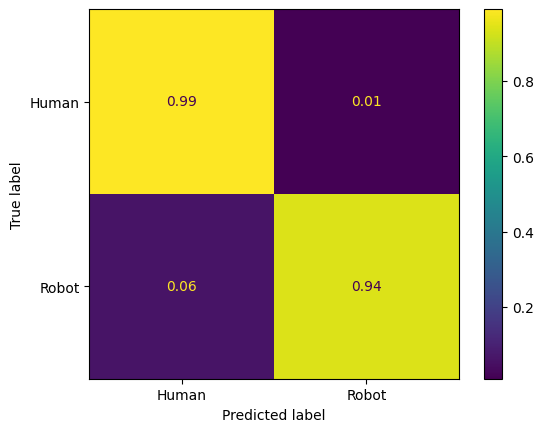

In [7]:
param_grid_bag = {'n_estimators': [30, 40, 50, 60, 70, 80], 'max_samples': [30000, 31000, 32000, 33000, 34000, 35000], 'bootstrap': [True, False], 'bootstrap_features': [True, False]}

grid_search_bag = GridSearchCV(BaggingClassifier(DecisionTreeClassifier(random_state=42), random_state=42), param_grid=param_grid_bag, cv=5, scoring='precision', return_train_score=True, n_jobs=-1)

grid_search_bag.fit(X_train, y_train)

print(grid_search_bag.best_params_)
print("\n")

bag_clf = grid_search_bag.best_estimator_

bag_clf.fit(X_train, y_train)

y_pred_bc = bag_clf.predict(X_test)

print(accuracy_score(y_test, y_pred_bc))
print("\n")
print(classification_report(y_test, y_pred_bc))

cm = np.round(confusion_matrix(y_test, y_pred_bc, normalize='true'), 2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Robot'])
disp.plot()

In [8]:
filename = '../main_models/bagging_classifier_no_oob_drop2.sav'
pickle.dump(bag_clf, open(filename, 'wb'))

##### BaggingClassifier met OOB

In [5]:
param_grid_bag = {'n_estimators': np.arange(30, 46, 2), 'max_samples': [13000, 14000, 15000, 16000, 17000, 18000]}

grid_search_bag_oob = GridSearchCV(BaggingClassifier(DecisionTreeClassifier(random_state=42), random_state=42, oob_score=True), param_grid=param_grid_bag, cv=5, scoring='precision', return_train_score=True, n_jobs=-1)

grid_search_bag_oob.fit(X_train, y_train)

print(grid_search_bag_oob.best_params_)
print("\n")

bag_clf_oob = grid_search_bag_oob.best_estimator_

bag_clf_oob.fit(X_train, y_train)

print(bag_clf_oob.oob_score_)

{'max_samples': 17000, 'n_estimators': 36}


0.9783343427042023


In [31]:
y_pred_oob = bag_clf_oob.predict(X_test)
accuracy_score(y_test, y_pred_oob)

0.9777291552707665

Is zeer dicht bij de OOB score

In [32]:
print(classification_report(y_test, y_pred_oob))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     10337
           1       0.95      0.94      0.94      2460

    accuracy                           0.98     12797
   macro avg       0.97      0.96      0.96     12797
weighted avg       0.98      0.98      0.98     12797



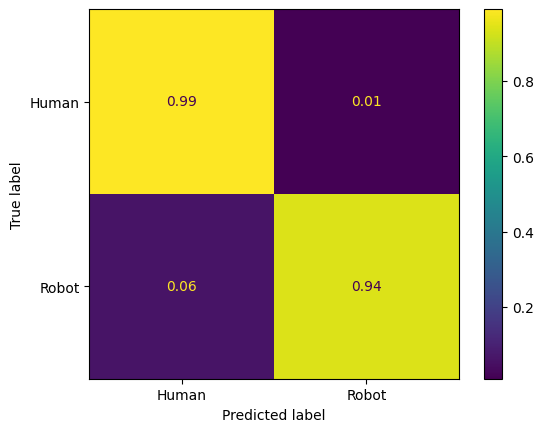

In [34]:
cm = np.round(confusion_matrix(y_test, y_pred_oob, normalize='true'), 2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Robot'])
disp.plot()

In [6]:
filename = '../main_models/bagging_classifier_oob_drop2.sav'
pickle.dump(bag_clf_oob, open(filename, 'wb'))

##### AdaBoostClassifier

{'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 10}


0.9774165820114089

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     10337
           1       0.95      0.93      0.94      2460

    accuracy                           0.98     12797
   macro avg       0.97      0.96      0.96     12797
weighted avg       0.98      0.98      0.98     12797



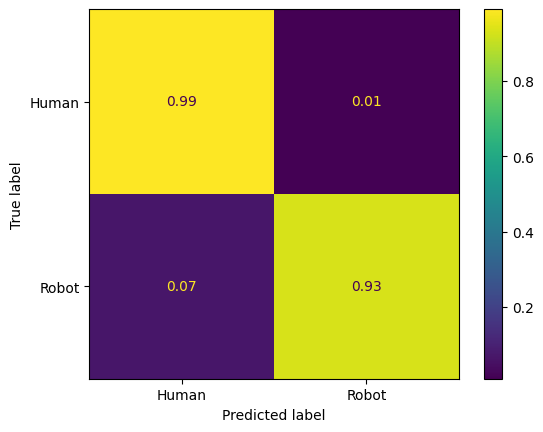

In [41]:
grid_search_ada = GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(random_state=42), random_state=42), param_grid={'n_estimators': [5, 10, 20, 30, 40, 50, 100, 200, 500], 'learning_rate': [0.1, 0.5, 1, 2], 'algorithm': ['SAMME.R']}, cv=5, scoring='precision', return_train_score=True, n_jobs=-1)

grid_search_ada.fit(X_train, y_train)

print(grid_search_ada.best_params_)
print("\n")

ada_clf = grid_search_ada.best_estimator_
ada_clf.fit(X_train, y_train)

y_pred_ada = ada_clf.predict(X_test)
print(f"{accuracy_score(y_test, y_pred_ada)}\n")

print(classification_report(y_test, y_pred_ada))

cm = np.round(confusion_matrix(y_test, y_pred_ada, normalize='true'), 2)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Robot'])
disp.plot()

In [43]:
filename = '../main_models/ada_boost_classifier_drop2.sav'
pickle.dump(ada_clf, open(filename, 'wb'))

##### GradientBoostClassifier

best_n_estimators --> list van MSE's --> kiezen index met laagste (minimum) MSE en + 1 omdat index op 0 start

(206 minuten om te runnen met 10 cpu cores)

In [8]:
param_grid_gradient = {'n_estimators': [25, 50, 100, 150, 200], 'learning_rate': [0.1, 0.5, 1, 2], 'max_depth': np.arange(1, 20) }

grid_search_gradient = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid=param_grid_gradient, cv=5, scoring='precision', return_train_score=True, n_jobs=-1)

grid_search_gradient.fit(X_train, y_train)

print(grid_search_gradient.best_params_)
print("\n")

gbrt = grid_search_gradient.best_estimator_
gbrt.fit(X_train, y_train)

errors_gbrt = [mean_squared_error(y_test, y_pred) for y_pred in gbrt.staged_predict(X_test)]

best_n_estimators = np.argmin(errors_gbrt) + 1
print(best_n_estimators)

{'learning_rate': 1, 'max_depth': 17, 'n_estimators': 200}


146


0.9803078846604673

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10337
           1       0.96      0.94      0.95      2460

    accuracy                           0.98     12797
   macro avg       0.97      0.97      0.97     12797
weighted avg       0.98      0.98      0.98     12797



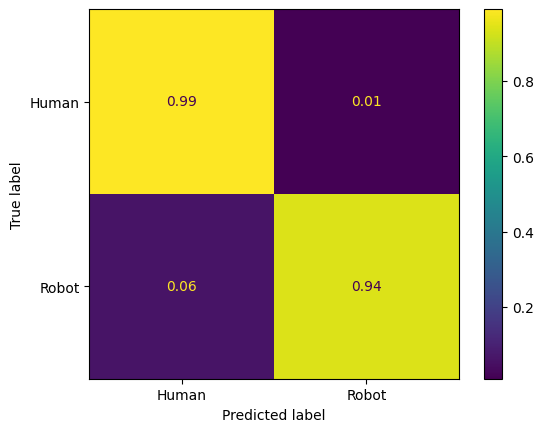

In [10]:
gbrt_best = GradientBoostingClassifier(max_depth=17, n_estimators=best_n_estimators, learning_rate=1, random_state=42)
gbrt_best.fit(X_train, y_train)

y_pred_gbrt = gbrt_best.predict(X_test)

print(f"{accuracy_score(y_test, y_pred_gbrt)}\n")

print(classification_report(y_test, y_pred_gbrt))

cm = np.round(confusion_matrix(y_test, y_pred_gbrt, normalize='true'), 2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Robot'])
disp.plot()

In [11]:
filename = '../main_models/gradient_boosting_classifier_drop2.sav'
pickle.dump(gbrt_best, open(filename, 'wb'))

##### RandomForestClassifier

207 minuten om te trainen

{'bootstrap': False, 'max_depth': 25, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 140}
0.9801515980307884

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10337
           1       0.95      0.95      0.95      2460

    accuracy                           0.98     12797
   macro avg       0.97      0.97      0.97     12797
weighted avg       0.98      0.98      0.98     12797



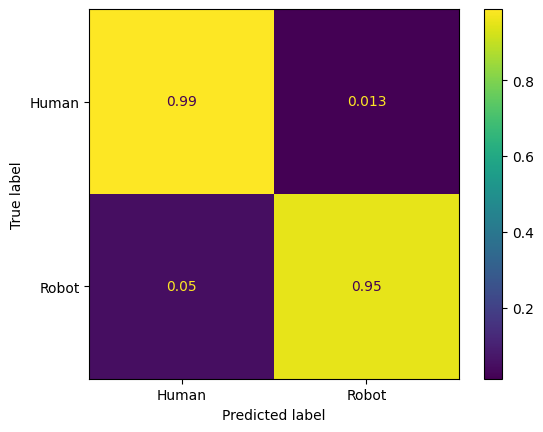

In [79]:
param_grid = {
    'n_estimators': np.arange(10, 200, 10),
    'max_depth': [1, 2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50],
    'min_samples_leaf' : [1, 2, 4],
    'min_samples_split' : [2, 5, 10],
    'bootstrap' : [True, False],
}

grid_search_rfc = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=param_grid, cv=5, n_jobs=-1)

grid_search_rfc.fit(X_train, y_train)

print(grid_search_rfc.best_params_)

rf_clf = grid_search_rfc.best_estimator_
rf_clf.fit(X_train, y_train)

y_pred_rfc = rf_clf.predict(X_test)
print(f"{accuracy_score(y_test, y_pred_rfc)}\n")

print(classification_report(y_test, y_pred_rfc))

cm = confusion_matrix(y_test, y_pred_rfc, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Robot'])
disp.plot()

In [82]:
np.round(confusion_matrix(y_test, y_pred_rfc, normalize='true'), 2)

array([[0.99, 0.01],
       [0.05, 0.95]])

In [ ]:
filename = '../main_models/random_forest_classifier_drop2.sav'
pickle.dump(rf_clf, open(filename, 'wb'))

### Met Scaling

In [5]:
from sklearn.pipeline import Pipeline

scaler = StandardScaler()

df = pd.read_csv('../data/weblogs1.csv')

X = df.drop(['ROBOT', 'ID', 'STANDARD_DEVIATION', 'SF_REFERRER', 'SF_FILETYPE', 'OTHER_METHOD', 'POST_METHOD', 'HEAD_METHOD', 'HTTP_RESPONSE_3XX',  'HTTP_RESPONSE_4XX', 'HTTP_RESPONSE_5XX','REPEATED_REQUESTS'], axis=1)
y = df['ROBOT']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### Decision Tree Classifier

{'max_depth': 16, 'min_samples_leaf': 3, 'min_samples_split': 16}
0.9750722825662265

              precision    recall  f1-score   support

           0       0.99      0.98      0.98     10337
           1       0.93      0.94      0.94      2460

    accuracy                           0.98     12797
   macro avg       0.96      0.96      0.96     12797
weighted avg       0.98      0.98      0.98     12797



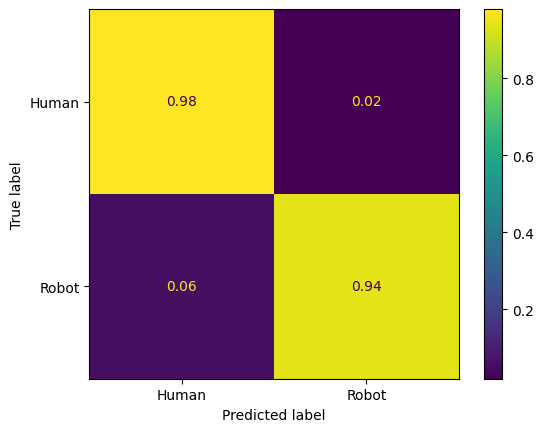

In [6]:
dt_clf_scaled = DecisionTreeClassifier(random_state=42)

pipeline = Pipeline([
    ('scaler', scaler),
    ('gs_dt_clf_scaled', GridSearchCV(dt_clf_scaled, param_grid=param_grid_dtc, cv=5, n_jobs=-1)),
])

pipeline.fit(X_train, y_train)

y_pred_pipeline = pipeline.predict(X_test)

print(pipeline['gs_dt_clf_scaled'].best_params_)

print(f"{accuracy_score(y_test, y_pred_pipeline)}\n")

print(classification_report(y_test, y_pred_pipeline))

cm = np.round(confusion_matrix(y_test, y_pred_pipeline, normalize='true'), 2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Robot'])
disp.plot()

##### BaggingClassifier (zonder OOB)

{'bootstrap': True, 'bootstrap_features': True, 'max_samples': 30000, 'n_estimators': 500}
0.9776510119559272

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     10337
           1       0.95      0.93      0.94      2460

    accuracy                           0.98     12797
   macro avg       0.97      0.96      0.96     12797
weighted avg       0.98      0.98      0.98     12797



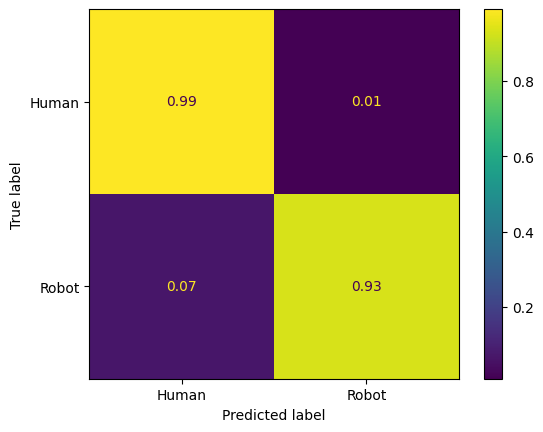

In [20]:
pipeline = Pipeline([
    ('scaler', scaler),
    ('grscv_bag_clf_scaled', GridSearchCV(BaggingClassifier(DecisionTreeClassifier(random_state=42), random_state=42), param_grid=param_grid_bag, cv=5, n_jobs=-1))
])

pipeline.fit(X_train, y_train)

y_pred_pipeline = pipeline.predict(X_test)

print(pipeline['grscv_bag_clf_scaled'].best_params_)

print(f"{accuracy_score(y_test, y_pred_pipeline)}\n")

print(classification_report(y_test, y_pred_pipeline))

cm = np.round(confusion_matrix(y_test, y_pred_pipeline, normalize='true'), 2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Robot'])
disp.plot()

##### BaggingClassifier (met OOB)

{'max_samples': 20000, 'n_estimators': 30}
0.9764788622333359

              precision    recall  f1-score   support

           0       0.98      0.99      0.99     10337
           1       0.95      0.93      0.94      2460

    accuracy                           0.98     12797
   macro avg       0.96      0.96      0.96     12797
weighted avg       0.98      0.98      0.98     12797



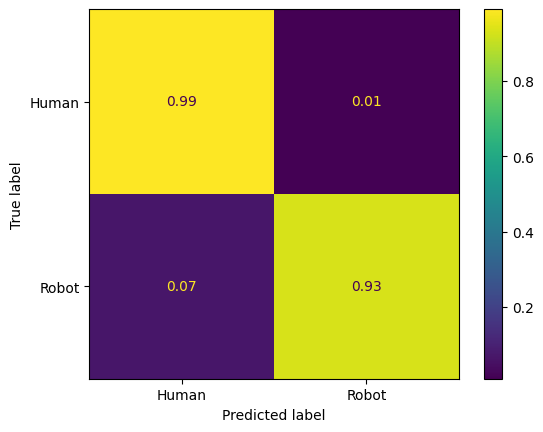

In [38]:
pipeline = Pipeline([
    ('scaler', scaler),
    ('grscv_bag_clf_oob_scaled', GridSearchCV(BaggingClassifier(DecisionTreeClassifier(random_state=42), random_state=42, oob_score=True), param_grid=param_grid_bag, cv=5, n_jobs=-1))
])

pipeline.fit(X_train, y_train)

print(pipeline['grscv_bag_clf_oob_scaled'].best_params_)

y_pred_pipeline = pipeline.predict(X_test)

print(f"{accuracy_score(y_test, y_pred_pipeline)}\n")

print(classification_report(y_test, y_pred_pipeline))

cm = np.round(confusion_matrix(y_test, y_pred_pipeline, normalize='true'), 2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Robot'])
disp.plot()

##### AdaBoostClassifier

{'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 10}
0.9745252793623506

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     10337
           1       0.95      0.92      0.93      2460

    accuracy                           0.97     12797
   macro avg       0.96      0.95      0.96     12797
weighted avg       0.97      0.97      0.97     12797



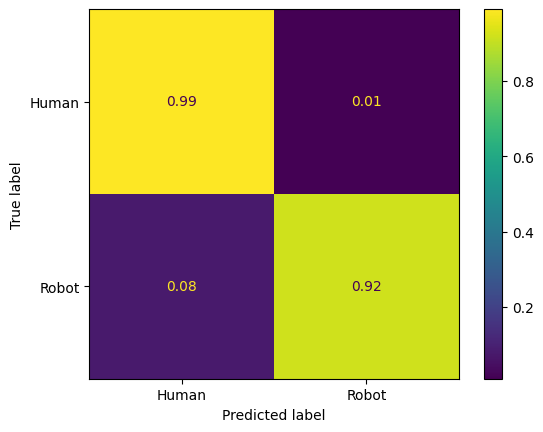

In [6]:
pipeline = Pipeline([
    ('scaler', scaler),
    ('gscv_ada_scaled', GridSearchCV(AdaBoostClassifier(DecisionTreeClassifier(random_state=42), random_state=42), param_grid={'n_estimators': [5, 10, 20, 30, 40, 50, 100, 200, 500], 'learning_rate': [0.1, 0.5, 1, 2], 'algorithm': ['SAMME.R']}, cv=5, scoring='precision', return_train_score=True, n_jobs=-1))
])

pipeline.fit(X_train, y_train)

print(pipeline['gscv_ada_scaled'].best_params_)

y_pred_pipeline = pipeline.predict(X_test)

print(f"{accuracy_score(y_test, y_pred_pipeline)}\n")

print(classification_report(y_test, y_pred_pipeline))

cm = np.round(confusion_matrix(y_test, y_pred_pipeline, normalize='true'), 2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Robot'])
disp.plot()

##### GradientBoostingClassifier

0.8085488786434321

              precision    recall  f1-score   support

           0       0.81      1.00      0.89     10337
           1       1.00      0.00      0.01      2460

    accuracy                           0.81     12797
   macro avg       0.90      0.50      0.45     12797
weighted avg       0.85      0.81      0.72     12797



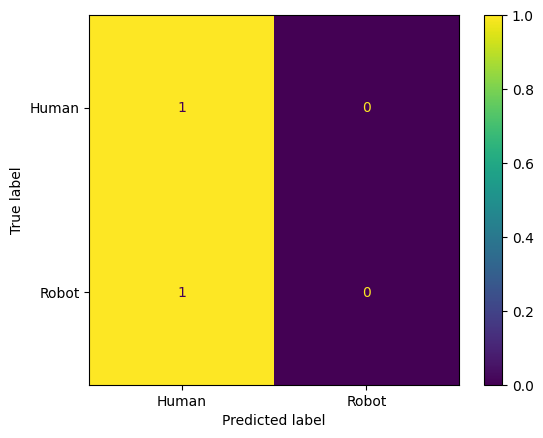

In [9]:
gbrt_best_scaled = GradientBoostingClassifier(max_depth=3, n_estimators=5, learning_rate=0.1, random_state=42)

pipeline = Pipeline([
    ('scaler', scaler),
    ('gbrt_best_scaled', gbrt_best_scaled),
])

pipeline.fit(X_train, y_train)

y_pred_pipeline = pipeline.predict(X_test)

print(f"{accuracy_score(y_test, y_pred_pipeline)}\n")

print(classification_report(y_test, y_pred_pipeline))

cm = np.round(confusion_matrix(y_test, y_pred_pipeline, normalize='true'), 2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Robot'])
disp.plot()

##### RandomForestClassifier

{'bootstrap': False, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 130}
0.9790575916230366

              precision    recall  f1-score   support

           0       0.99      0.99      0.99     10337
           1       0.95      0.94      0.95      2460

    accuracy                           0.98     12797
   macro avg       0.97      0.96      0.97     12797
weighted avg       0.98      0.98      0.98     12797



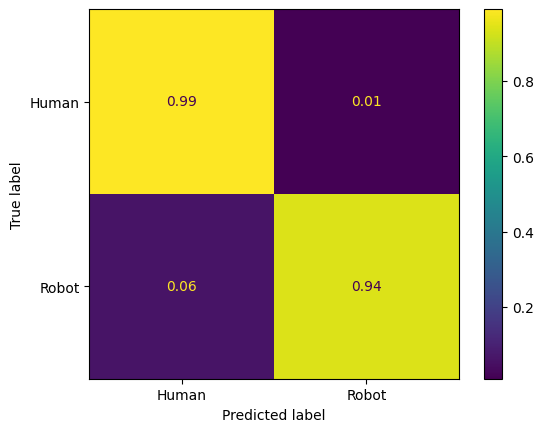

In [7]:
param_grid_rfc = {
    'n_estimators': np.arange(50, 160, 10),
    'max_depth': [1, 2, 5, 10, 15, 20, 25, 30],
    'min_samples_leaf' : [1, 2, 4],
    'min_samples_split' : [2, 5, 10],
    'bootstrap' : [True, False],
}

grid_search_rfc_scaled = GridSearchCV(RandomForestClassifier(random_state=42), param_grid=param_grid_rfc, cv=5, scoring='precision', return_train_score=True, n_jobs=-1)

pipeline = Pipeline([
    ('scaler', scaler),
    ('grsc_rf_clf_scaled', grid_search_rfc_scaled),
])

pipeline.fit(X_train, y_train)

print(pipeline['grsc_rf_clf_scaled'].best_params_)

rf_clf_scaled = pipeline['grsc_rf_clf_scaled'].best_estimator_

rf_clf_scaled.fit(X_train, y_train)

y_pred_rf_scaled = rf_clf_scaled.predict(X_test)

print(f"{accuracy_score(y_test, y_pred_rf_scaled)}\n")

print(classification_report(y_test, y_pred_rf_scaled))

cm = np.round(confusion_matrix(y_test, y_pred_rf_scaled, normalize='true'), 2)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Human', 'Robot'])
disp.plot()

Conclusie --> scaling heeft de resultaten slechter gemaakt